In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Input, Conv1D, MaxPooling1D, Add
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
dataset_label = pd.read_csv('key_point_data/hand1.csv', header=None).values
print(np.shape(dataset_label))

(99, 63)


In [2]:
# Define the dataset
text = [
    "Hello Guys",
    "How are you"
]
labels = dataset_label

# Tokenize and preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
vocab_size = len(tokenizer.word_index) + 1

max_sequence_length = 10  # maximum length of input sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

num_encoder_tokens = vocab_size
batch_size = 1
num_decoder_tokens = 63
latent_dim = 128
max_sequence_length = 20  # maximum length of input sequences
epochs = 2

print(num_encoder_tokens, num_decoder_tokens, latent_dim, max_sequence_length)

encoder_input_data = padded_sequences
decoder_input_data = labels[:-1]
decoder_target_data = labels[1:]

6 63 128 20


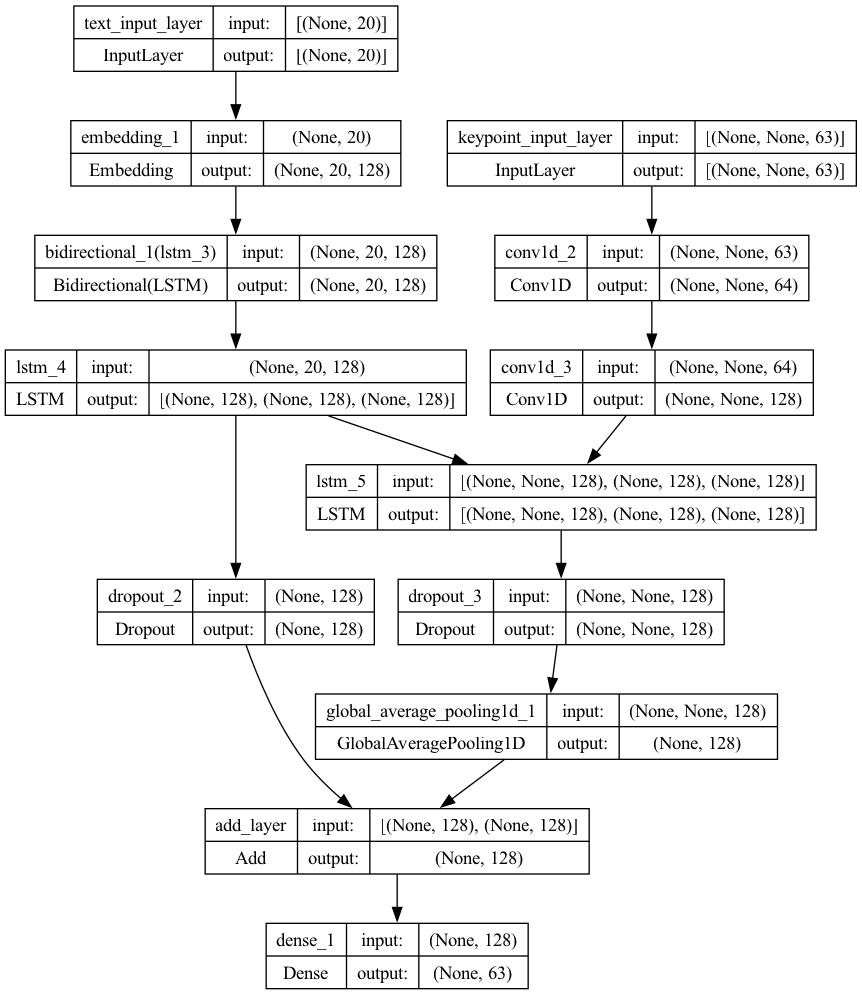

In [4]:
encoder_input_layer = Input(shape=(max_sequence_length), name='text_input_layer')
encoder = Embedding(num_encoder_tokens, latent_dim, input_length=max_sequence_length)(encoder_input_layer)
encoder = Bidirectional(LSTM(units = 64, return_sequences=True))(encoder)
encoder, state_h, state_c = LSTM(units = 128, return_state=True)(encoder)
encoder_states = [state_h,state_c]
encoder = Dropout(0.2)(encoder)

decoder_input_layer = Input(shape=(None,num_decoder_tokens), name='keypoint_input_layer')
decoder = Conv1D(filters=64, kernel_size=3, activation='relu')(decoder_input_layer)
decoder = Conv1D(filters=128, kernel_size=3, activation='relu')(decoder)
decoder_outputs, _, _ = LSTM(units = 128, return_state=True,return_sequences=True)(decoder,initial_state=encoder_states)
decoder = Dropout(rate = 0.2)(decoder_outputs)
decoder = GlobalAveragePooling1D()(decoder)

add_layer = Add(name='add_layer')([encoder, decoder])
output_layer = Dense(63, activation='linear')(add_layer)

model = Model(inputs=[encoder_input_layer, decoder_input_layer], outputs=output_layer)

plot_model(model, to_file='model_visualize/model_plot.png', show_shapes=True, show_layer_names=True)